In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession\
  .builder \
  .appName("Streaming 1") \
  .config("spark.sql.streaming.schemaInference", "true") \
  .getOrCreate()


Размещаем файлы в папке

In [ ]:
df = spark.readStream \
    .format("json") \
    .option("path", "/content/input") \
    .option("maxFilesPerTrigger", 1) \
    .load()

In [ ]:
df_2 = df.selectExpr("InvoiceNumber",
                     "CreatedTime",
                     "StoreID",
                     "PosID",
                     "CashierID",
                     "CustomerType",
                     "CustomerCardNo",
                     "TotalAmount",
                     "NumberOfItems",
                     "PaymentMethod",
                     "TaxableAmount",
                     "explode(InvoiceLineItems) as Item"
                     )

In [ ]:
from pyspark.sql.functions import expr
#{"ItemCode":"523","ItemDescription":"Oil-lamp clock","ItemPrice":1371.0,"ItemQty":2,"TotalValue":2742.0}

df_3 = df_2 \
    .withColumn("ItemCode", expr("Item.ItemCode")) \
    .withColumn("ItemDescription", expr("Item.ItemDescription")) \
    .withColumn("ItemPrice", expr("Item.ItemPrice")) \
    .withColumn("ItemQty", expr("Item.ItemQty")) \
    .withColumn("TotalValue", expr("Item.TotalValue")) \
    .drop("Item")


In [ ]:
query = df_3.writeStream \
  .format("json") \
  .option("path", "/content/output") \
  .option("checkpointLocation", "check-dir") \
  .trigger(processingTime = "30 seconds") \
  .start()

{'id': '0385cf37-ac53-481a-b9e0-30eccd514ec3',
 'runId': '46516738-a6ee-4898-a593-7ba4391de0ea',
 'name': None,
 'timestamp': '2024-11-28T16:56:00.000Z',
 'batchId': 3,
 'numInputRows': 0,
 'inputRowsPerSecond': 0.0,
 'processedRowsPerSecond': 0.0,
 'durationMs': {'latestOffset': 5, 'triggerExecution': 7},
 'stateOperators': [],
 'sources': [{'description': 'FileStreamSource[file:/content/input]',
   'startOffset': {'logOffset': 2},
   'endOffset': {'logOffset': 2},
   'latestOffset': None,
   'numInputRows': 0,
   'inputRowsPerSecond': 0.0,
   'processedRowsPerSecond': 0.0}],
 'sink': {'description': 'FileSink[/content/output]', 'numOutputRows': -1}}

In [ ]:
spark.stop()

Задание 2

Создаем сессию

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession\
  .builder \
  .appName("Streaming 2") \
  .config("spark.sql.streaming.schemaInference", "true") \
  .getOrCreate()

1)Определим структуру будущего датафрейма

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

schema = StructType([
    StructField("createdTime", StringType()),
    StructField("price", DoubleType()),
    StructField("quantity", IntegerType()),
    StructField("type", StringType())
])




Создаем датафрейм

In [ ]:
df = spark.readStream \
    .format("json") \
    .option("path", "/content/input2") \
    .option("maxFilesPerTrigger", 1) \
    .schema(schema) \
    .load()



Генерация данных

In [ ]:
import time
import random
import json


# создаем от 5 до 10 файлов с небольшим количеством объектов
# в каждом файле сдвигаем временную метку на 4 сек
for frame in range(random.randint(5, 20)):
  with open(f"input2/{frame}.json", "w") as file:
    for _ in range(random.randint(10, 20)):
      file.write(json.dumps({
        "createdTime": int(time.time()) + 4 * frame,
        "price": random.randint(1000, 10_000) / 100,
        "quantity":random.randint(100, 2000),
        "type": random.choice(['type1', 'type2', 'type3'])
      }))
      file.write("\n")


Исходная схема: createdTime - string, а должен быть timestamp

In [ ]:
df.printSchema()

root
 |-- createdTime: string (nullable = true)
 |-- price: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- type: string (nullable = true)



In [ ]:
from pyspark.sql.functions import to_timestamp, col, current_timestamp, from_unixtime
df_2 = df\
  .withColumn("createdTime", to_timestamp(from_unixtime(col("createdTime"))))

In [ ]:
df_2.printSchema()

root
 |-- createdTime: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- type: string (nullable = true)



Создаем агрегацию с оконной функцией, которая разбивает наши данные на равные отрезки - по 5 секунд, в рамках которых и производятся агрегации
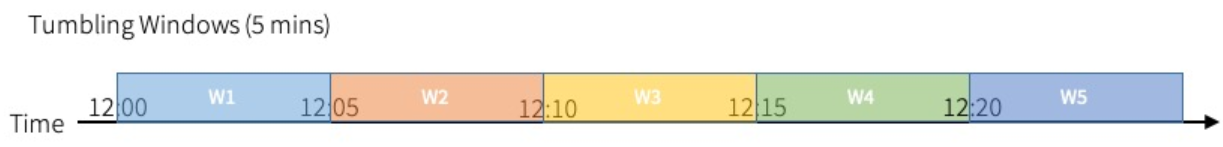

In [ ]:
from pyspark.sql.functions import window, col, avg, max



agg_df = df_2 \
    .groupBy(
        window(col("createdTime"), "10 seconds")
    ) \
    .agg(
      avg("price").alias("avg_price"),
      max("quantity").alias("max_quantity"))


In [ ]:
result_df = agg_df.select("window.start", "window.end", "avg_price", "max_quantity")

In [ ]:
result_df.printSchema()

root
 |-- start: timestamp (nullable = true)
 |-- end: timestamp (nullable = true)
 |-- avg_price: double (nullable = true)
 |-- max_quantity: integer (nullable = true)



Опция `.outputMode("complete")` указыает на то, что в результате получаем один df в котором будут актуальные данные (обновляются все строки)

In [ ]:
query = result_df.writeStream \
  .format("memory") \
  .outputMode("complete") \
  .option("queryName", "second_query2") \
  .option("checkpointLocation", "check-dir-6") \
  .trigger(processingTime = "5 seconds") \
  .start()

In [ ]:
query.lastProgress

{'id': '80d6f38f-378d-4c9e-ae8a-09424e64a998',
 'runId': 'e406670e-c22a-4ae7-9f76-293c8fedfa60',
 'name': 'second_query2',
 'timestamp': '2024-12-12T15:46:35.001Z',
 'batchId': 7,
 'numInputRows': 0,
 'inputRowsPerSecond': 0.0,
 'processedRowsPerSecond': 0.0,
 'durationMs': {'latestOffset': 3, 'triggerExecution': 3},
 'stateOperators': [{'operatorName': 'stateStoreSave',
   'numRowsTotal': 3,
   'numRowsUpdated': 0,
   'allUpdatesTimeMs': 628,
   'numRowsRemoved': 0,
   'allRemovalsTimeMs': 0,
   'commitTimeMs': 16639,
   'memoryUsedBytes': 87232,
   'numRowsDroppedByWatermark': 0,
   'numShufflePartitions': 200,
   'numStateStoreInstances': 200,
   'customMetrics': {'loadedMapCacheHitCount': 2400,
    'loadedMapCacheMissCount': 0,
    'stateOnCurrentVersionSizeBytes': 21448}}],
 'sources': [{'description': 'FileStreamSource[file:/content/input2]',
   'startOffset': {'logOffset': 6},
   'endOffset': {'logOffset': 6},
   'latestOffset': None,
   'numInputRows': 0,
   'inputRowsPerSecond

In [ ]:
spark.sql("SELECT * FROM second_query2").show()

+-------------------+-------------------+------------------+------------+
|              start|                end|         avg_price|max_quantity|
+-------------------+-------------------+------------------+------------+
|2024-12-12 15:39:20|2024-12-12 15:39:30|56.353599999999986|        1990|
|2024-12-12 15:39:30|2024-12-12 15:39:40|59.317727272727275|        2000|
|2024-12-12 15:39:10|2024-12-12 15:39:20|            56.965|        1967|
+-------------------+-------------------+------------------+------------+



Запись в файл после кадждого обновления (после каждого нового считанного batch)

In [ ]:
currentBatch = 0
while not query.awaitTermination(5):
  lastProgress = query.lastProgress
  print(lastProgress)
  if lastProgress['numInputRows'] == 0:
    query.stop()
  else:
    batchId = lastProgress['batchId']
    if currentBatch <= batchId:
      spark.sql("SELECT * FROM second_query2").write.json(f"output2/{batchId}.json")
      currentBatch = batchId + 1


{'id': 'bb0b68f3-57df-4f53-a76e-459f61100d69', 'runId': 'b80ea800-035d-4aef-b59e-7588b08f80fe', 'name': 'second_query2', 'timestamp': '2024-12-12T16:03:05.000Z', 'batchId': 15, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0, 'durationMs': {'latestOffset': 3, 'triggerExecution': 4}, 'stateOperators': [{'operatorName': 'stateStoreSave', 'numRowsTotal': 6, 'numRowsUpdated': 0, 'allUpdatesTimeMs': 620, 'numRowsRemoved': 0, 'allRemovalsTimeMs': 0, 'commitTimeMs': 16952, 'memoryUsedBytes': 87976, 'numRowsDroppedByWatermark': 0, 'numShufflePartitions': 200, 'numStateStoreInstances': 200, 'customMetrics': {'loadedMapCacheHitCount': 5600, 'loadedMapCacheMissCount': 0, 'stateOnCurrentVersionSizeBytes': 22096}}], 'sources': [{'description': 'FileStreamSource[file:/content/input2]', 'startOffset': {'logOffset': 14}, 'endOffset': {'logOffset': 14}, 'latestOffset': None, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0}], 'sink': {'description'

Запись в файл после считывания всех файлов (легче и предпочтительнее)

In [ ]:
currentBatch = 0
while not query.awaitTermination(5):
  lastProgress = query.lastProgress
  print(lastProgress)
  if lastProgress['numInputRows'] == 0:
    spark.sql("SELECT * FROM second_query2").write.json(f"output2/{batchId}.json")
    query.stop()

In [ ]:
!rm -r /content/check-dir-6/
!rm -r /content/input2/
!mkdir /content/input2

rm: cannot remove '/content/check-dir-6/': No such file or directory


In [ ]:
spark.stop()

Задание 3

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession\
  .builder \
  .appName("Streaming 3") \
  .config("spark.sql.streaming.schemaInference", "true") \
  .getOrCreate()

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

schema = StructType([
    StructField("createdTime", StringType()),
    StructField("price", DoubleType()),
    StructField("quantity", IntegerType()),
    StructField("type", StringType())
])


In [ ]:
df = spark.readStream \
    .format("json") \
    .option("path", "/content/input2") \
    .option("maxFilesPerTrigger", 1) \
    .schema(schema) \
    .load()

In [ ]:
import time
import random
import json


# создаем от 5 до 10 файлов с небольшим количеством объектов
# в каждом файле сдвигаем временную метку на 4 сек
for frame in range(random.randint(5, 20)):
  with open(f"input2/{frame}.json", "w") as file:
    for _ in range(random.randint(10, 20)):
      file.write(json.dumps({
        "createdTime": int(time.time()) + 4 * frame,
        "price": random.randint(1000, 10_000) / 100,
        "quantity":random.randint(100, 2000),
        "type": random.choice(['type1', 'type2', 'type3'])
      }))
      file.write("\n")

In [ ]:
from pyspark.sql.functions import to_timestamp, col, current_timestamp, from_unixtime
df_2 = df\
  .withColumn("createdTime", to_timestamp(from_unixtime(col("createdTime"))))

Sliding windows - _скользит_ по данным с заданным параметром.
В данном случае имеем
```python
window(col("createdTime"), "10 seconds", "5 second")
```
10 секунд - ширина окна

5 секунд - сдвиг

Визуализация из документации:
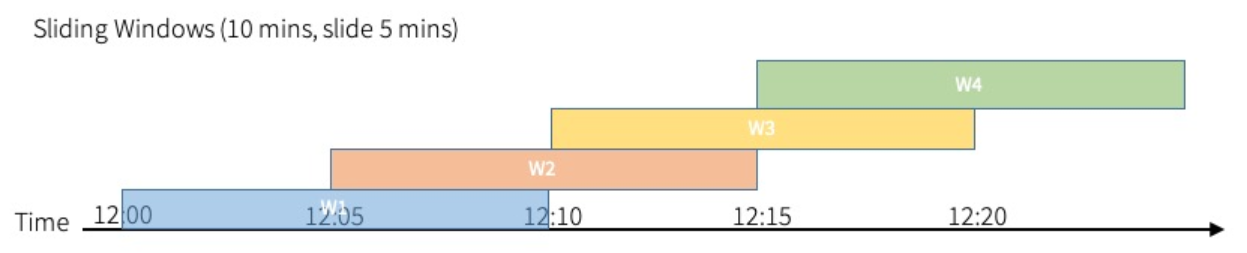

In [ ]:
from pyspark.sql.functions import window, col, avg, max



agg_df = df_2 \
    .groupBy(
        window(col("createdTime"), "10 seconds", "5 second")
    ) \
    .agg(
      avg("price").alias("avg_price"),
      max("quantity").alias("max_quantity"))

In [ ]:
result_df = agg_df.select("window.start", "window.end", "avg_price", "max_quantity")

Опция `.outputMode("update") \` указывает, что данные будут дописываться в конец df. Таким образом, можно отследить историю изменения значения

In [ ]:
query = result_df.writeStream \
  .format("memory") \
  .outputMode("update") \
  .option("queryName", "second_query2") \
  .option("checkpointLocation", "check-dir-6") \
  .trigger(processingTime = "5 seconds") \
  .start()

In [ ]:
spark.sql("SELECT * FROM second_query2").show()

+-------------------+-------------------+------------------+------------+
|              start|                end|         avg_price|max_quantity|
+-------------------+-------------------+------------------+------------+
|2024-11-28 21:08:00|2024-11-28 21:08:10|60.204687500000006|        1864|
|2024-11-28 21:07:30|2024-11-28 21:07:40| 55.33387096774193|        1865|
|2024-11-28 21:08:30|2024-11-28 21:08:40|56.085483870967735|        1940|
|2024-11-28 21:08:20|2024-11-28 21:08:30| 58.73325581395349|        1940|
|2024-11-28 21:08:10|2024-11-28 21:08:20| 53.93555555555557|        1975|
|2024-11-28 21:07:40|2024-11-28 21:07:50| 52.98116279069767|        1979|
|2024-11-28 21:07:50|2024-11-28 21:08:00| 44.94466666666666|        1988|
+-------------------+-------------------+------------------+------------+



In [ ]:
spark.stop()

In [ ]:
!rm -r /content/check-dir-6/
!rm -r /content/input2/
!mkdir /content/input2